In [1]:
from models.coarsenet import CoarseNet
from models.finenet import FineNet
import matplotlib.pyplot as plt
import torch 
import rawpy
import cv2
import utils
import torch.nn as nn
import numpy as np
import os
import time
from glob import glob
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

## Utils function

In [2]:
def load_coarse_model(path="checkpoints/coarse_e300.pth"):
    coarseModel = CoarseNet()
    coarseModel.load_state_dict(torch.load(path, map_location='cpu'))
    coarseModel.eval()
    return coarseModel

def load_fine_model(path='checkpoints/fine_e345.pth'):
    fineModel = FineNet()
    fineModel.load_state_dict(torch.load(path, map_location='cpu'))
    fineModel.eval()
    return fineModel

def load_dataset(path = "dataset/Sony_train_list.txt"):
    with open(path, 'r')  as f:
        paths = f.readlines()
    root = 'dataset'
    input_paths = [os.path.join(root, l.split(' ')[0]) for l in paths]
    gt_paths = [os.path.join(root, l.split(' ')[1]) for l in paths]
    input_exposure = [float(os.path.split(input_file)[-1][9:-5]) for input_file in input_paths] # 0.04
    gt_exposure = [float(os.path.split(gt_file)[-1][9:-5]) for gt_file in gt_paths]
    ratios = np.array(gt_exposure)/np.array(input_exposure)
    return input_paths, gt_paths, ratios

def load_and_preprocess_input(coarseModel, path, ratio, cuda):
    raw_input = rawpy.imread(path)
    raw_input = utils.pack_raw(raw_input) * ratio
    raw_input = np.clip(raw_input, 0, 1)
    raw_input = cv2.resize(raw_input, (2128, 1424), cv2.INTER_LINEAR)
    
    # prepare input 
    inp = raw_input.transpose(2, 0, 1)
    inp_raw = torch.Tensor(inp)
    inp_raw = inp_raw.unsqueeze(0)

    if cuda:
        inp_raw = inp_raw.cuda()
    out_coarse = coarseModel(inp_raw)
    noise_x = inp_raw - out_coarse
    
    inpFine = torch.cat([inp_raw , out_coarse, noise_x], dim = 1)
    return inpFine

def bgr2rgb(img):
    b,g,r = img[:,:,0].copy(), img[:,:,1].copy(), img[:,:,2].copy()
    img[:,:,0] = r
    img[:,:,1] = g
    img[:,:,2] = b
    return img

def fit(fineModel, inpFine):
    with torch.no_grad():
        outFine = fineModel(inpFine)
        outFine = torch.clamp(outFine, 0, 1)
        outFine = outFine.squeeze(0).permute(1, 2, 0)
    return outFine.cpu().data.numpy() * 255

In [4]:
def main(input_path, ratio, cuda):
    root = 'testing_imgs/'
    img_name = input_path.split('/')[-1].split('.')[0] +'_r' + str(ratio)
    coarseModel = load_coarse_model()
    fineModel = load_fine_model()
    
    if cuda:
        coarseModel.cuda()
        fineModel.cuda()

    # prepare input, preprocess input, feed to coarse model to get fully features 
    inpFine = load_and_preprocess_input(coarseModel, input_path, ratio, cuda)
    
    pred_img = fit(fineModel, inpFine)
    pred_img = pred_img.astype(int)
    
    saved = cv2.imwrite(root + img_name + '_pred.jpg', pred_img)
    if saved:
        print('saved prediction image successfully!')
    pred_img = bgr2rgb(pred_img)
        
    plt.figure(figsize=(20,10))
    plt.imshow(pred_img)
    plt.show()

## Main

saved prediction image successfully!


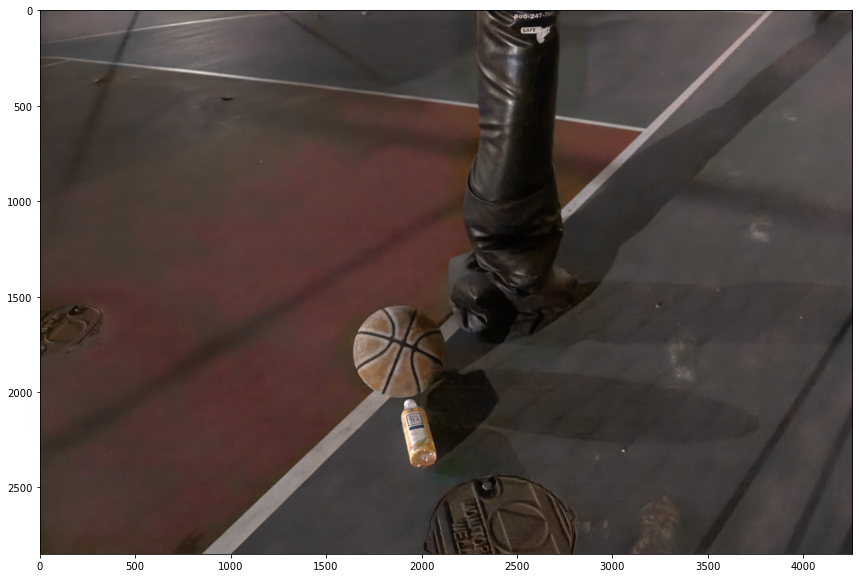

total time: 14.639026165008545


In [7]:
st = time.time()
main('testing_imgs/10011_04_0.1s.ARW', 200, False)
print(f'total time: {time.time() -st}')

saved prediction image successfully!


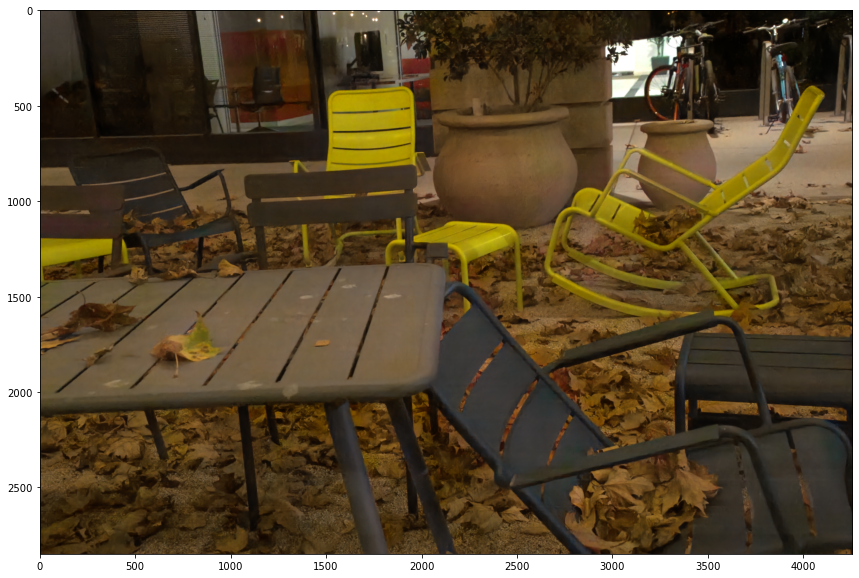

total time: 14.804964542388916


In [18]:
st = time.time()
main('testing_imgs/10022_00_0.1s.ARW', 250, False)
print(f'total time: {time.time() -st}')

#### PSNR over all testing

* total testing files: 598
* psnr: 28.55
* ssim: 0.79

#### PSNR and SSIM ignoring some unaligned files 

In [8]:
from glob import glob

In [8]:
psnr = np.load('test/psnr.npy')
ssim = np.load('test/ssim.npy')

* ignore unaligned files: 10034, 10045, 10172

In [9]:
def load_dataset(path = "dataset/Sony_test_list.txt"):
    with open(path, 'r')  as f:
        paths = f.readlines()
    root = 'dataset'
    input_paths = [os.path.join(root, l.split(' ')[0]) for l in paths]
    gt_paths = [os.path.join(root, l.split(' ')[1]) for l in paths]
    input_exposure = [float(os.path.split(input_file)[-1][9:-5]) for input_file in input_paths] # 0.04
    gt_exposure = [float(os.path.split(gt_file)[-1][9:-5]) for gt_file in gt_paths]
    ratios = np.array(gt_exposure)/np.array(input_exposure)
    return input_paths, gt_paths, ratios

In [10]:
input_paths, gt_paths, ratios = load_dataset("dataset/Sony_test_list.txt")

In [11]:
input_paths = np.array(input_paths)

In [12]:
tmp_input_paths = np.array([p.split('/')[-1][:5] for p in input_paths])

In [13]:
ignored_indices1 = np.argwhere(tmp_input_paths=='10034').flatten()
ignored_indices2 = np.argwhere(tmp_input_paths=='10045').flatten()
ignored_indices3 = np.argwhere(tmp_input_paths=='10172').flatten()
ignored_indices = np.concatenate((ignored_indices1 , ignored_indices2 , ignored_indices3))

In [14]:
ignored_indices

array([ 86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       374, 375, 376, 377, 378, 379, 380, 381, 382, 383])

In [15]:
psnr_clean = np.array([p for idx, p in enumerate(psnr) if idx not in ignored_indices])
ssim_clean = np.array([p for idx, p in enumerate(ssim) if idx not in ignored_indices])

In [16]:
np.mean(psnr_clean), np.mean(ssim_clean)

(28.919308010195834, 0.7935955283617843)

* psnr: 28.91
* ssim: 0.79